# Model with an extended set of featuress

In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)
from imblearn.over_sampling import SMOTE
# List of columns
pre_fight_columns = [
    'r_age','r_height','r_reach','r_wins_total','r_losses_total','r_stance',
    'r_SLpM_total','r_SApM_total','r_sig_str_acc_total','r_str_def_total',
    'r_td_avg','r_td_acc_total','r_td_def_total','r_sub_avg',
    'b_age','b_height','b_reach','b_wins_total','b_losses_total','b_stance',
    'b_SLpM_total','b_SApM_total','b_sig_str_acc_total','b_str_def_total',
    'b_td_avg','b_td_acc_total','b_td_def_total','b_sub_avg',
    'weight_class','is_title_bout',
    'age_diff','height_diff','reach_diff','wins_total_diff','losses_total_diff',
    'SLpM_total_diff','SApM_total_diff','sig_str_acc_total_diff','str_def_total_diff',
    'td_avg_diff','td_acc_total_diff','td_def_total_diff','sub_avg_diff',
    'winner'
]

df_pre_fight = pd.read_csv("../data/ufc_pre_fight_men_ready2.csv")

X = df_pre_fight.drop(columns=["winner"])
y = df_pre_fight["winner"]

# Chronological split
split_index = int(len(df_pre_fight) * 0.2)
X_train = X.iloc[split_index:]  # older fights
y_train = y.iloc[split_index:]
X_test = X.iloc[:split_index]   # new fights
y_test = y.iloc[:split_index]

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

# Oversampling 
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Model RandomForest with the best parameters
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='log2',
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Training
rf_model.fit(X_train_res, y_train_res)

# Probability function
def predict_fight(model, X_input, threshold=0.5):
    # Returns the predicted probability of the red corner winning and the predicted label based on the threshold.
    winner_prob = model.predict_proba(X_input)[:, 1]  # probability of red winning
    winner_label = (winner_prob >= threshold).astype(int)
    return winner_prob, winner_label

# Prediction on test data
threshold = 0.5
y_prob, y_pred = predict_fight(rf_model, X_test, threshold=threshold)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# # Probability for first 10 fights
# print("\nFirst 10 fights sample:")
# for i, prob in enumerate(y_prob[:10], 1):
#     print(f"Fight {i}: {prob:.2f}, Prediction: {'Red wins' if y_pred[i-1]==1 else 'Blue wins'}")


Train size: 4560, Test size: 1140
Accuracy: 0.7157894736842105
Precision: 0.7450424929178471
Recall: 0.7850746268656716
F1 Score: 0.7645348837209303

Confusion Matrix:
 [[290 180]
 [144 526]]

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.62      0.64       470
           1       0.75      0.79      0.76       670

    accuracy                           0.72      1140
   macro avg       0.71      0.70      0.70      1140
weighted avg       0.71      0.72      0.71      1140



## Barplot of Feature Importance

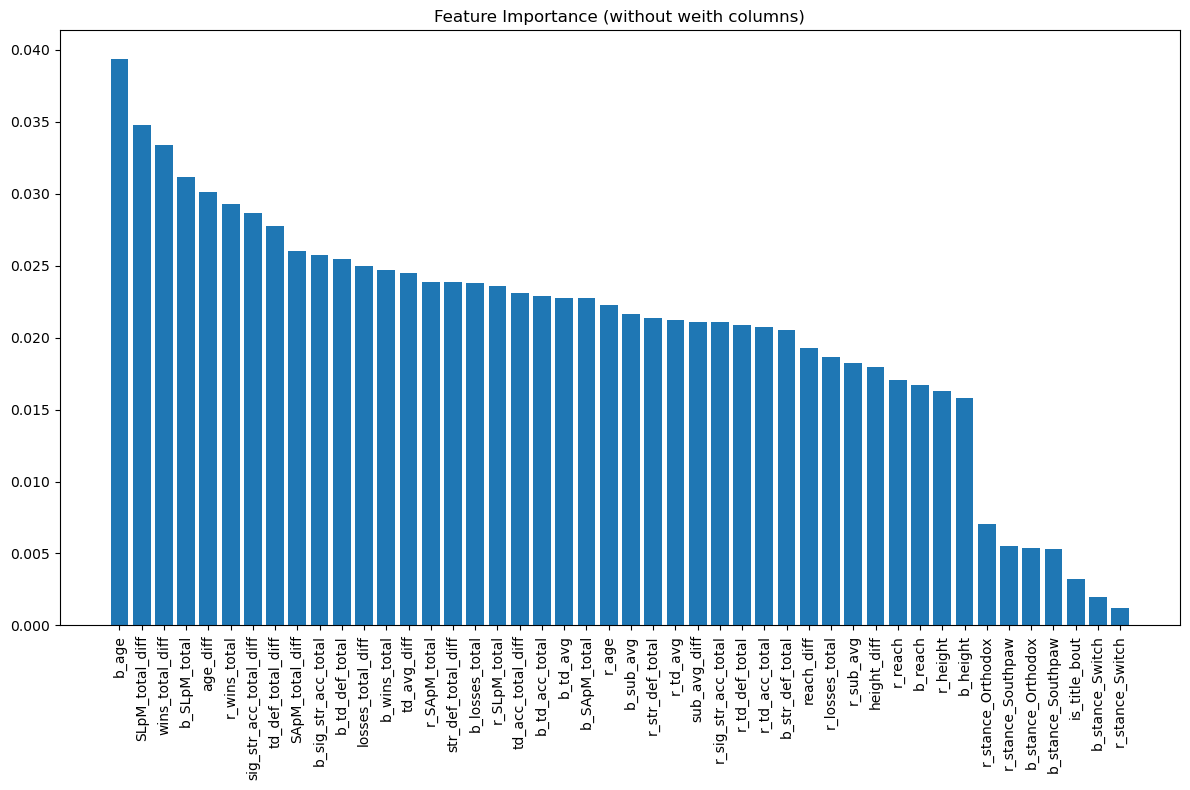

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Removing 'weight' column
feature_mask = [col for col in X_train.columns if "weight" not in col]
X_train_filtered = X_train[feature_mask]

# Feature importance from trained model
importances = rf_model.feature_importances_

# We only match the filtered features
importances_filtered = [importances[i] for i, col in enumerate(X_train.columns) if col in feature_mask]

indices = np.argsort(importances_filtered)[::-1]

plt.figure(figsize=(12,8))
plt.title("Feature Importance (without weith columns)")
plt.bar(range(len(importances_filtered)), np.array(importances_filtered)[indices], align='center')
plt.xticks(range(len(importances_filtered)), [feature_mask[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

## Saving model

In [21]:
import pickle
model_filename = "../model/ufc_rf_model_2.pkl"

with open(model_filename, "wb") as f:
    pickle.dump({
        "model": rf_model,             # trained RandomForest
        "features": X_train.columns.tolist()  # list of features
    }, f)

print(f"Model saved to {model_filename} file")

Model saved to ../model/ufc_rf_model_2.pkl file


## Brier Score

Brier Score measures the mean squared error of predicted probabilities.
Lower values indicate better calibrated and more accurate probabilistic predictions.



In [22]:
from sklearn.metrics import brier_score_loss

# Brier Score
brier = brier_score_loss(y_test, y_prob)
print("Brier Score:", brier)

Brier Score: 0.20174924012581055


## Calibration Curve

Calibration curve compares predicted probabilities to observed win frequencies.
A perfectly calibrated model lies on the diagonal (y = x).


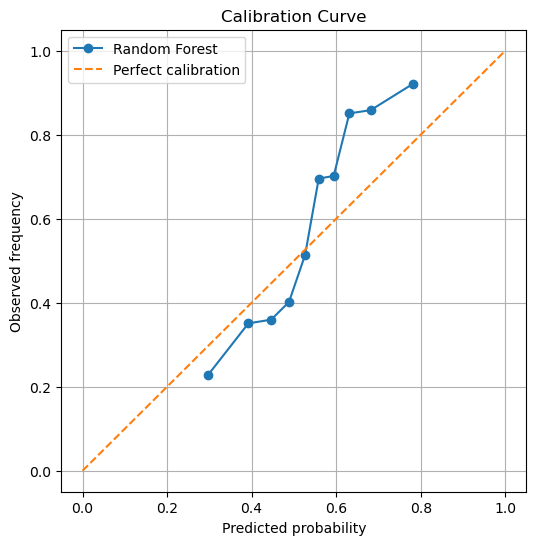

In [23]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Calibration Curve
prob_true, prob_pred = calibration_curve(
    y_test,
    y_prob,
    n_bins=10,
    strategy="quantile"
)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label="Random Forest")
plt.plot([0,1], [0,1], linestyle='--', label="Perfect calibration")
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)
plt.show()

## Brier Calibration

Probability calibration adjusts raw model outputs to better match true outcome frequencies.
It improves probability reliability without changing the model's ranking ability.


In [24]:
from sklearn.calibration import CalibratedClassifierCV

cal_rf = CalibratedClassifierCV(
    rf_model,
    method="isotonic",
    cv=5
)

cal_rf.fit(X_train_res, y_train_res)

y_prob_cal = cal_rf.predict_proba(X_test)[:,1]

print(
    "Brier (calibrated):",
    brier_score_loss(y_test, y_prob_cal)
)

Brier (calibrated): 0.1957276383028006
